# Contributor-Project Weighted Network Edges Discussion

The purpose of this notebook is to provide insight into the logic of the `calc_recency_weights` and `calc_tfidf_weights` methods in the `graph_helper_functions.ipynb` notebook. For our purposes, we will be performing a graphical analysis on contributors who've created issues in repositories within HuggingFace and KubeFlow, however, our work can be extended to other contribution types and repository groups.

In [1]:
!pip install networkx

In [2]:
import sqlalchemy as salc
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx

from sklearn.preprocessing import MinMaxScaler

from  ipynb.fs.full.graph_helper_functions import preprocess

## Connect to Augur Database

In [3]:
with open("../../comm_cage.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

Before we get started, let's first define some helper functions that we will use throughout this analysis.

In [4]:
def repo_query(repo_group):
  """
  :param repo_group: A String representing the name of a repository group

  returns a List of all repository ids belonging to the repository group
  """

  repo_group_query = salc.sql.text(f"""
                          SELECT r.repo_id
                          FROM repo r, repo_groups rg
                          WHERE r.repo_group_id = rg.repo_group_id
                          AND rg.rg_name = '{repo_group}';
                      """)


  with engine.connect() as conn:
        result = conn.execute(repo_group_query)
        repo_ids = [r for r, in result]
  return repo_ids

In [5]:
def issue_query(repo_ids):
  """
  :param repo_ids: a List of repository ids belonging to the same repository group
  returns a DataFrame containing issue data with repository ids, repository urls,
          contributor ids, issue ids, and timestamps,
  """
  issue_contrib = pd.DataFrame()
  for repo_id in repo_ids:
      repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT r.repo_id,
                    r.repo_git,
                    i.cntrb_id,
                    i.issue_id,
                    i.created_at
                    FROM
                    repo r, issues i
                    WHERE
                    i.repo_id = \'{repo_id}\' AND
                    i.repo_id = r.repo_id
              """)
      with engine.connect() as conn:
            df_current_repo = pd.read_sql(repo_query, con=conn)
      issue_contrib = pd.concat([issue_contrib, df_current_repo])

  issue_contrib = issue_contrib.reset_index()
  issue_contrib.drop("index", axis=1, inplace=True)
  issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id', 'created_at']
  return issue_contrib

## Recency weights
Intuitively, we want to weigh contributor-project network edges by the recency of a specific action type to gain insight into which contributors have recently contributed to a project and how active a project is currently. Recency weights will range from 0 to 1 where the more recent a contribution to a project is, the closer to 1 it will be. The derivation of recency weights will be outlined the following steps: first we will analyze the distribution of the variable of interest to build intuition for potential feature mappings, next we will implement mapping, and finally, we will demonstrate a potential intended use case. We will perform our following analysis on issue contributors in HuggingFace.

First, let's analyze the distribution of differences between the most recent issue creation timestamp and all the other timestamps to get intuition on an appropriate feature mapping.


In [6]:
# retrieve availible repos in HuggingFace
hf_repo_ids = repo_query('huggingface')
print(hf_repo_ids)

[66038, 66041, 66062, 66005, 66000, 66052, 66098, 66028, 66069, 65986, 65981, 66009, 66040, 66018, 66034, 66029, 66075, 66027, 66035, 66026, 66015, 66023, 66022, 66008, 66047, 66068, 66016, 66096, 66100, 65998, 66039, 66051, 65975, 66056, 66071, 65985, 66092, 66025, 65996, 66073, 66019, 66086, 66082, 66017, 66003, 66049, 66067, 65990, 66048, 66013, 65978, 66001, 66094, 66089, 66043, 65979, 66042, 66065, 65987, 65976, 66099, 65993, 66090, 66070, 66061, 66055, 66046, 66036, 66080, 66074, 65994, 66012, 66002, 66085, 65983, 66060, 66078, 66014, 65997, 66095, 66037, 66021, 66059, 66084, 66088, 66031, 65980, 66057, 66050, 66033, 66006, 66054, 66077, 66010, 66007, 66024, 66063, 66072, 66102, 66066, 66083, 66076, 66087, 66030, 66079, 66045, 65999, 65982, 66044, 66064, 65989, 66101, 66091, 66004, 65984, 66081, 66058, 65991, 65977, 65988, 66097, 65992, 66093, 66032, 65995, 66020, 66053, 66011]


In [7]:
# get issue data for each repo in HuggingFace
hf_issue_contrib = issue_query(hf_repo_ids)

# make a copy of hf_issue_contrib and convert timestamps from strings to datetime objects and convert contributor ids from UUIDs to strings and abbreviate
recency_issue_contrib = preprocess(hf_issue_contrib)
display(recency_issue_contrib.head())

,repo_id,repo_git,cntrb_id,issue_id,created_at
0,66005,https://github.com/huggingface/datasets-viewer,01028ddb,27493293,2021-07-21 09:31:46+00:00
1,66005,https://github.com/huggingface/datasets-viewer,None,27493291,2021-10-01 15:37:05+00:00
2,66005,https://github.com/huggingface/datasets-viewer,None,27493292,2021-07-21 10:10:03+00:00
3,66005,https://github.com/huggingface/datasets-viewer,None,27493295,2021-06-21 16:29:52+00:00
4,66005,https://github.com/huggingface/datasets-viewer,None,27493298,2020-09-15 23:40:41+00:00


In [8]:
# count the number of contributions each contributor has made to repo
contributionsbyRepo = recency_issue_contrib.groupby(['repo_id', 'cntrb_id']).size().to_frame()
contributionsbyRepo = contributionsbyRepo.reset_index()
contributionsbyRepo = contributionsbyRepo.rename(columns={0: 'num_cntrbs'})

# get the most recent 'created_at' value
most_recent = max(recency_issue_contrib['created_at'])

recency_issue_contrib['time_diff'] = recency_issue_contrib.apply(
        lambda row: (float((most_recent - row.created_at).days)), axis=1
        )

recency_issue_contrib['time_diff'].describe()

count    27824.000000
mean       639.080686
std        487.134855
min          0.000000
25%        203.000000
50%        522.000000
75%       1044.000000
max       2449.000000
Name: time_diff, dtype: float64

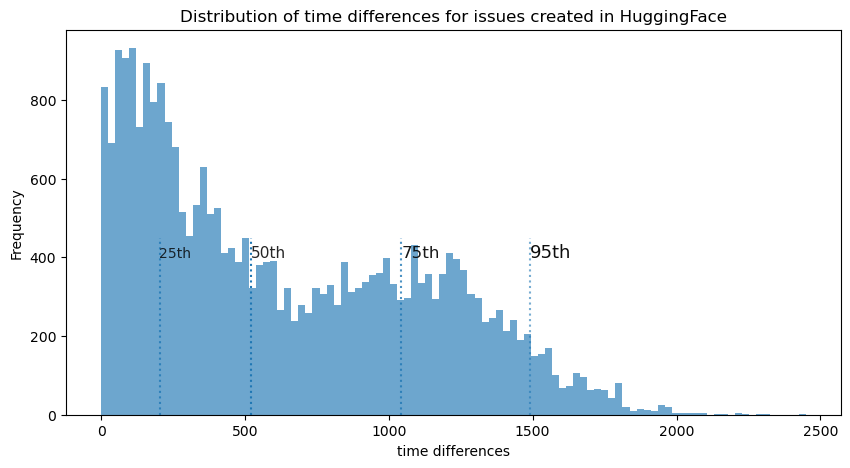

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

recency_issue_contrib['time_diff'].plot(kind = "hist", alpha = 0.65, bins = 100)

# determine 25th, 50th, 75th, and 95th quantiles
quant_25, quant_50, quant_75, quant_95 =  recency_issue_contrib['time_diff'].quantile(0.25),  recency_issue_contrib['time_diff'].quantile(0.5), recency_issue_contrib['time_diff'].quantile(0.75), recency_issue_contrib['time_diff'].quantile(0.95)

# [quantile, opacity, length]
quants = [[quant_25, 0.8, 0.46], [quant_50, 1, 0.46],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.46]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# add annotations
ax.text(quant_25-.13, 400, "25th", size = 10, alpha = 0.80)
ax.text(quant_50-.13, 400, "50th", size = 11, alpha = 0.85)
ax.text(quant_75-.13, 400, "75th", size = 12, alpha = 0.90)
ax.text(quant_95-.25, 400, "95th", size = 13, alpha =.95)

ax.set_title(f'Distribution of time differences for issues created in HuggingFace')
ax.set_xlabel('time differences')

plt.show()

The distribution of time differences is clearly skewed right, meaning that most of the issues in HuggingFace's repositories were created recently. This makes sense as HuggingFace's libraries such as have exploded in popularity in conjunction with LLM hype. We can expect the number of issues created to increase as a project expands. We cannot directly use the time differences as weights because they would drastically alter the value of the edge weights in the network. Furthermore, more recent contributions would have significantly more weight than less recent ones. For these reasons, there is need for a feature mapping to transform the time differences to the reduce their skewdness and scale them between 0 and 1.

In [10]:
# get the most recent 'created_at' value
most_recent = max(recency_issue_contrib['created_at'])

# apply feature mapping
recency_issue_contrib['recency_weights'] =  recency_issue_contrib.apply(
        lambda row: (-np.sqrt(float((most_recent - row.created_at).days))) if ((most_recent - row.created_at).days) !=0 else 1, axis=1
        )

# scale weights to be between 0 and 1
scaler = MinMaxScaler()
recency_issue_contrib['recency_weights'] = scaler.fit_transform(recency_issue_contrib[['recency_weights']])

display(recency_issue_contrib.head())

,repo_id,repo_git,cntrb_id,issue_id,created_at,time_diff,recency_weights
0,66005,https://github.com/huggingface/datasets-viewer,01028ddb,27493293,2021-07-21 09:31:46+00:00,834.0,0.408187
1,66005,https://github.com/huggingface/datasets-viewer,None,27493291,2021-10-01 15:37:05+00:00,762.0,0.433436
2,66005,https://github.com/huggingface/datasets-viewer,None,27493292,2021-07-21 10:10:03+00:00,834.0,0.408187
3,66005,https://github.com/huggingface/datasets-viewer,None,27493295,2021-06-21 16:29:52+00:00,864.0,0.397991
4,66005,https://github.com/huggingface/datasets-viewer,None,27493298,2020-09-15 23:40:41+00:00,1143.0,0.310555


Before we demonstrate an example use case, let's do a sanity check to ensure that the recency weights gradually decrease as time differences increase. Let's also visualize their distribution.

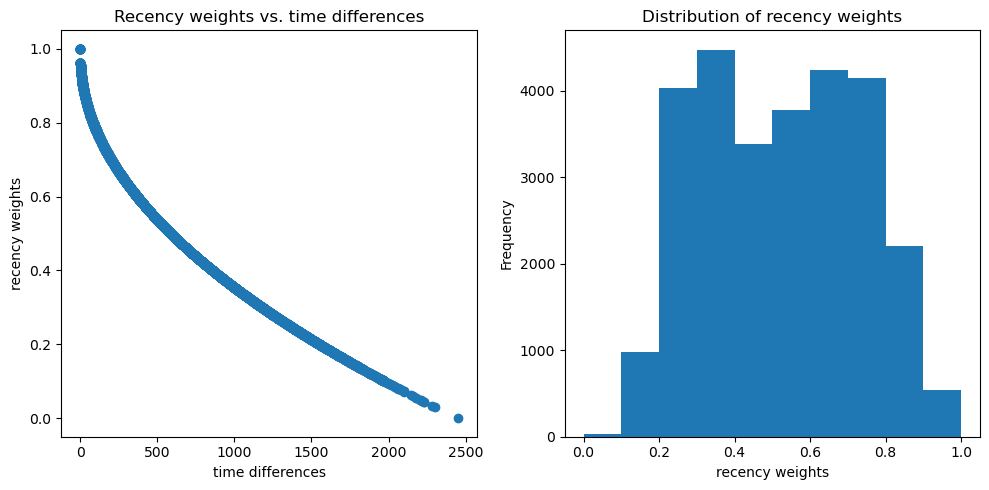

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter( recency_issue_contrib['time_diff'],  recency_issue_contrib['recency_weights'])
ax[0].set_title('Recency weights vs. time differences')
ax[0].set_xlabel('time differences')
ax[0].set_ylabel('recency weights')

ax[1].hist(recency_issue_contrib['recency_weights'])
ax[1].set_title('Distribution of recency weights')
ax[1].set_xlabel('recency weights')
ax[1].set_ylabel('Frequency')

fig.tight_layout()
plt.show()

Please refer to the `calc_recency_weights` method in `graph_helper_functions.ipynb` for the compact implementation of calculating recency weights.

## HuggingFace's Contributor-Project Network with Edges Weighted by Recency

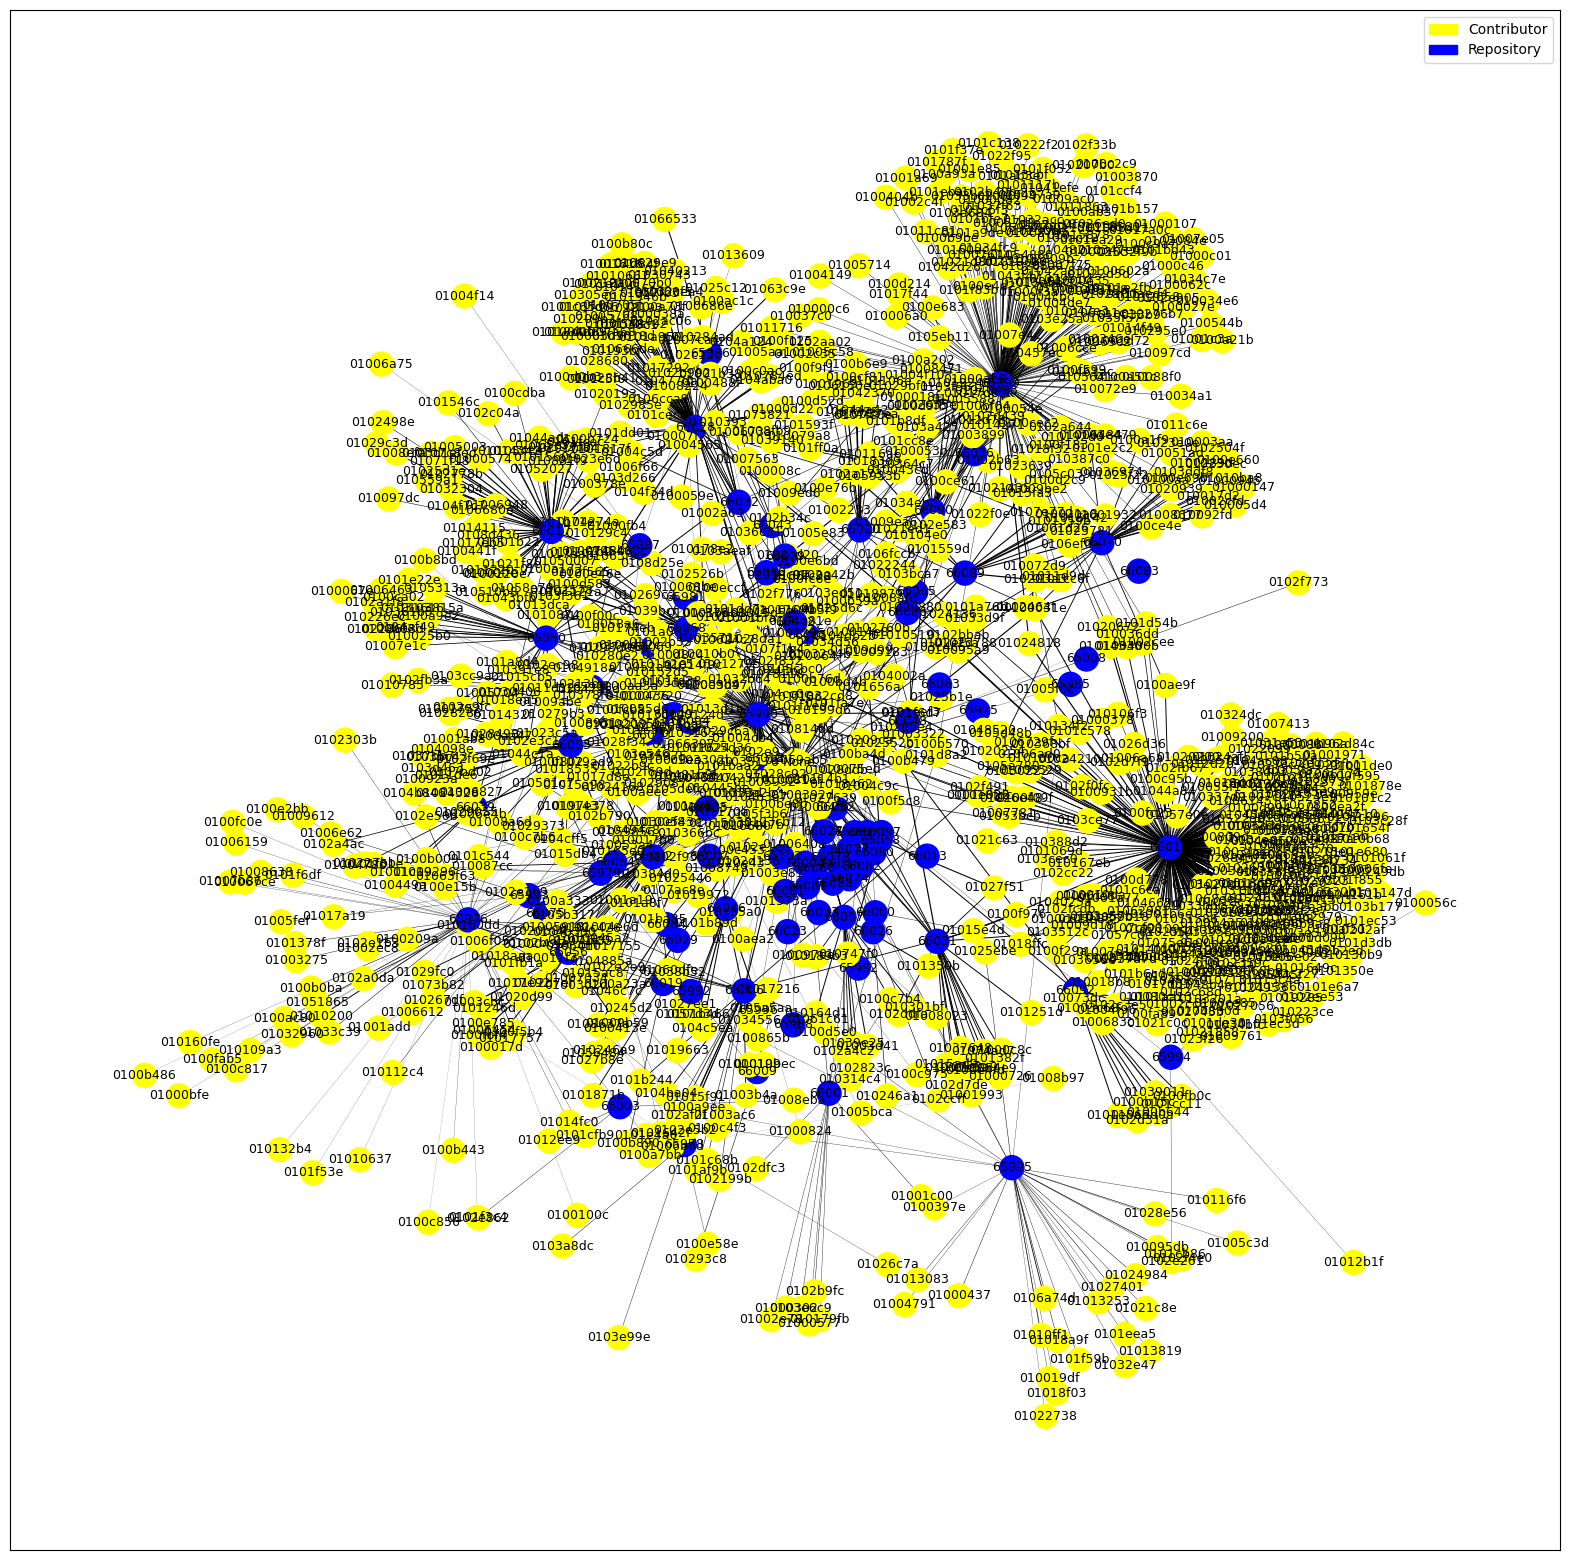

In [12]:
# initialize graph
G = nx.Graph()

# add nodes and edges
for i, row in recency_issue_contrib.iterrows():
  G.add_node(row['cntrb_id'])
  G.add_node(row['repo_id'])
  G.add_edge(row['cntrb_id'], row['repo_id'], weight= row['recency_weights'])

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(20,20))

# distinguish between contributors and projects
nodes = G.nodes()
colors = ['blue' if n in hf_repo_ids else 'yellow' for n in nodes]
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])

# define edge widths and labels
edge_widths = [G[u][v]['weight']  for u,v in G.edges()]
labels = {k:k for k in nodes}

nx.draw_networkx_nodes(G, pos=pos, node_color=colors, ax=ax)
nx.draw_networkx_edges(G, pos=pos, width=edge_widths)
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=9)
plt.show()

Clearly, there are some projects within HuggingFace that are more relevant currently in terms of issues created than others. We see the darkest egdes connecting contributors to repository corresponding to ID 66017 which is their AutoTrain Advanced library. This doesn't come as a surprise given that it is a no-code tool to train models for NLP, CV, Speech and Tabular tasks that has been developed recently.



## TF-IDF Weights

According to NLP theory, TF-IDF is used to measure how important a term in a document is amongst a corpus. It is the product of 2 statistics: TF (term frequency) and IDF (inverse document frequency).

$$\text{Let TF be the relative frequency of term t within document d}\\tf(t, d) = \frac{f_{t,d}}{\sum{f_{t^\prime,d}}}$$


$$\text{Let IDF be a measure of how much information the word provides}\\idf(t, D) = \frac{N}{|\{d ∈ D: t ∈ T\}|}\\ \text{with N: the total number of documents within the corpus} \\ \text{and |\{d ∈ D: t ∈ d\}|: the total number of documents the term t appears in}$$

$$\text{Thus,}\, TF*IDF =  tf(t, d)*idf(t,D)$$

In our analysis, we adjust the terms of TF-IDF to measure how important a contributor is to a repository in a repository group. The major distinction between TF-IDF and other measures of contributor importance is that it measures how well we can identify a repository based solely on its contributor. It can indicate if a repository requires specialized knowlegde for contributors to participate in. We perform the following analysis on issue contributors in KubeFlow but again, our methods can be extended to any contribution type and repository group.

In [13]:
# retrieve availible repos in KubeFlow
kf_repo_ids = repo_query('kubeflow')
print(kf_repo_ids)

[71293, 71289, 71285, 71313, 71292, 71303, 71297, 71301, 71316, 71302, 71319, 71295, 71310, 71320, 71290, 71311, 71317, 71294, 71306, 71300, 71309, 71296, 71308, 71314, 71305, 71312, 71299, 71307, 71318, 71315, 71291, 71287, 71288, 71304, 71298, 71286, 71321]


In [14]:
# get issue data for each repo in KubeFlow
kf_issue_contrib = issue_query(kf_repo_ids)

# make a copy of kf_issue_contrib and convert timestamps from strings to datetime objects and convert contributor ids from UUIDs to strings and abbreviate
tfidf_issue_contrib = preprocess(kf_issue_contrib)
display(tfidf_issue_contrib.head())

,repo_id,repo_git,cntrb_id,issue_id,created_at
0,71293,https://github.com/kubeflow/caffe2-operator,None,28613895,2018-03-29 03:08:11+00:00
1,71289,https://github.com/kubeflow/examples,01019296,28615155,2019-12-23 12:50:50+00:00
2,71289,https://github.com/kubeflow/examples,01000bdc,28615156,2019-12-17 21:28:43+00:00
3,71289,https://github.com/kubeflow/examples,01000bdc,28615157,2019-12-13 09:51:46+00:00
4,71289,https://github.com/kubeflow/examples,010089d6,28615158,2019-12-12 16:22:27+00:00


## Calculate TF
First, let's calculate the TF term of TF-IDF. We replace the orginal definitions of *t* and *d* with the raw count of a individual's contributions *t* to a repository *d* such that TF is now defined as the relative frequency of an individual's contribution *t* within repository *d*.

In [15]:
# count the number of contributions by repo and contributor
tfidf_issue_contrib = tfidf_issue_contrib.groupby(['repo_id', 'cntrb_id']).size().to_frame()
tfidf_issue_contrib = tfidf_issue_contrib.reset_index()
tfidf_issue_contrib = tfidf_issue_contrib.rename(columns={0:'num_cntrbs'})

# count the number of contributions by repo
contributonsByRepo = tfidf_issue_contrib.groupby(['repo_id'])['num_cntrbs'].sum().to_dict()

tf = tfidf_issue_contrib.apply(lambda row: row.num_cntrbs / contributonsByRepo[row.repo_id], axis=1)

## Calculate IDF
Next, let's calculate the IDF term. Again, we replace the orginal definitions of *N* and |{d ∈ D: t ∈ d}| with the total number of repositories in a repo group *N* and the total number of repositories that a contributor contributes to |{d ∈ D: t ∈ d}|.


In [16]:
# count the total number of repos in the repo group
totalRepos = tfidf_issue_contrib['repo_id'].nunique()

# count the number of repos each contributor has contributed to
repoContributionsByContributor = tfidf_issue_contrib.groupby('cntrb_id')['repo_id'].count().to_dict()

idf = tfidf_issue_contrib.apply(lambda row: np.log(totalRepos / repoContributionsByContributor[row.cntrb_id]), axis=1)

## Calculate TF*IDF

In [17]:
tfidf_issue_contrib['tf_idf'] = (tf * idf)
display(tfidf_issue_contrib.head())

,repo_id,cntrb_id,num_cntrbs,tf_idf
0,71285,None,847,0.000000
1,71286,None,3793,0.000000
2,71287,None,2,0.000000
3,71288,None,346,0.000000
4,71289,010000d4,1,0.008888


Please refer to the `calc_tfidf_weights` method in `graph_helper_functions.ipynb` for the compact implementation of calculating TF-IDF weights.

## Kubeflow's Contributor-Project Network with Edges Weighted by TF-IDF

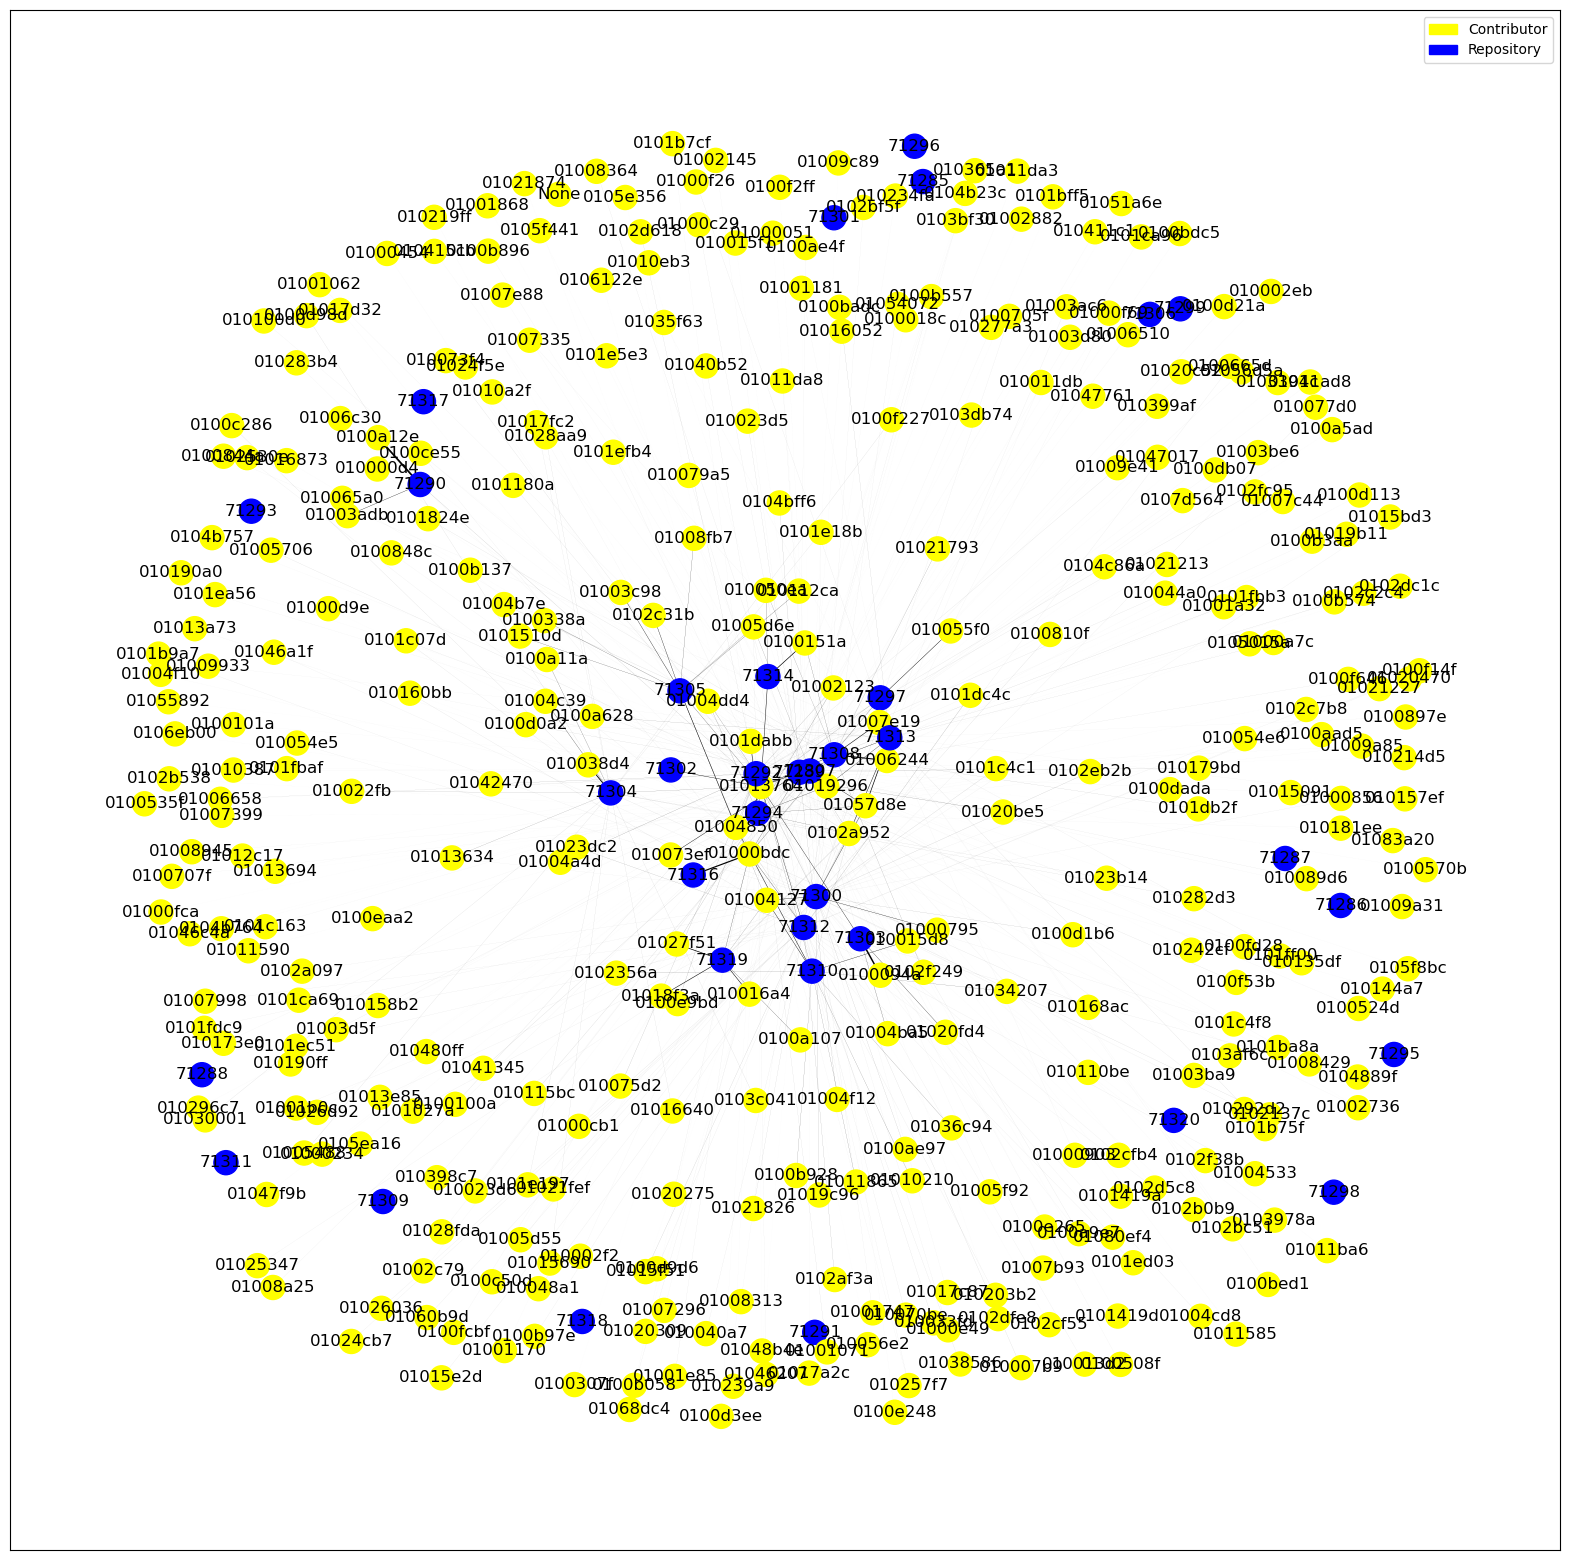

In [18]:
# initialize graph
G1 = nx.Graph()

# add nodes and edges
for i, row in tfidf_issue_contrib.iterrows():
  G1.add_node(row['cntrb_id'])
  G1.add_node(row['repo_id'])
  G1.add_edge(row['cntrb_id'], row['repo_id'], weight= row['tf_idf'])

pos = nx.spring_layout(G1, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(20,20))

# distinguish between contributors and projects
colors = ['blue' if n in kf_repo_ids else 'yellow' for n in G1.nodes()]
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])

# define edge widths and labels
edge_widths = [G1[u][v]['weight']  for u,v in G1.edges()]
labels = {k:k for k in G1.nodes()}

nx.draw_networkx_nodes(G1, pos=pos, node_color=colors, ax=ax)
nx.draw_networkx_edges(G1, pos=pos, width=edge_widths)
nx.draw_networkx_labels(G1, pos=pos, labels=labels)

plt.show()

It appears that the projects with the most "focused" contributors are mainly in the center of the plot. In this context, we define focused contributors as those who have created many issues in a project and very few in others. The darker the egde connection, the more focused a contributor is to a project, according to our formulation of TF-IDF weights. For example, we can observe several dark egdes connecting contributors to the repository corresponding to ID 71292 or the PyTorch Operator project in Kubeflow. Semantically, this means that this repository has a high issue creation volume from a large set contributors who create significantly less issues in other KubeFlow repositories. 